In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
Home = str(Path.home())

import numpy as np
import pandas as pd

import re

import sys
path = f'{Home}/repos/EPObjects/'
sys.path.insert(0, path)

from Probabilistic.Parameter import ProbabilisticParameters
from Probabilistic.EnergyPredictions import EnergyPrediction, ProbabilisticEnergyPrediction

from Helper.MLHelper import GetGenerator, GetRegressor, GetScalingLayer, Rescaling
from Helper.RunPeriodHelper import GetRunPeriodsFromFile

In [2]:
ColorsSolid = ['#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#ff7f0e',]
NumColors = len(ColorsSolid)

def RGBToHex(c):
    c = c.astype(np.int16)
    return '#%02x%02x%02x' %(c[0], c[1], c[2])

def HexToRGB(h):
    return np.array([int(h[i:i+2], base=16) for i in (1, 3, 5)], dtype=np.int16)

def GetWeighedColor(col1, col2='#ffffff', w=0.5):
    c1 = HexToRGB(col1)
    c2 = HexToRGB(col2)
    return RGBToHex((c1 * (1-w)) + (w * c2))

class ColorScale:
    def __init__(self, c1, c2, mi, ma):
        self.Color1 = c1
        self.Color2 = c2
        self.Min = mi
        self.Max = ma
        self.Range = self.Max - self.Min
        
    def Color(self, value):
        if isinstance(value, np.ndarray):     
            vs = []
            for v in value:
                vs.append(GetWeighedColor(self.Color1, self.Color2, (v-self.Min)/self.Range))
            return vs
        return GetWeighedColor(self.Color1, self.Color2, (value-self.Min)/self.Range)

In [16]:
TestPath = f'{Home}/repos/EPObjects/Tausendpfund/'
Number = 1
pps = ProbabilisticParameters.ReadCsv(f'{TestPath}/Parameters.csv')
_, Targets = GetRunPeriodsFromFile(f'{TestPath}/Consumption.csv')

In [17]:
pEnergies = []
for i in range(200):
    data = pd.read_csv(f'{TestPath}/IDFFiles-{Number}/{i}.csv', index_col=0)
    data.index = range(len(data))
    pEnergies += [EnergyPrediction(None, data)]

SimulationData = ProbabilisticEnergyPrediction(None, pEnergies)
Results = SimulationData.Values['Total']

In [21]:
g = GetGenerator(None, 100, list(str(x.Parameter) for x in pps), f'{TestPath}/MLModel-{Number}/Generator', f'{path}/MLModel-{Number}/Regressor.h5', None, None, training=False)
Combinations = g.Predict(1, numModels=50, mean=False)

r = GetRegressor(None, list(str(x.Parameter) for x in pps), SimulationData.Values['Total'].columns, f'{TestPath}/MLModel-{Number}/Regressor', None, None, training=False)
_ = r.Predict(Combinations)

2023-04-03 15:39:43.500645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


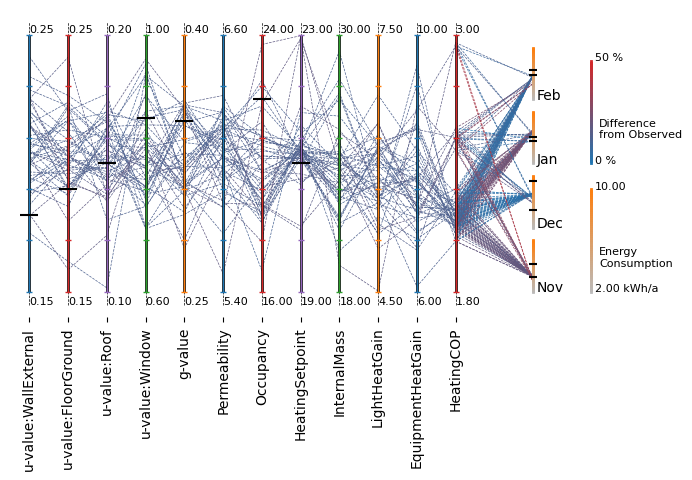

In [22]:
mi = np.array([pp.Min for pp in pps])
ra = np.array([pp.Max-pp.Min for pp in pps])
ScalingX = Rescaling(1./ra, offset = -mi/ra)
SampleScaled = ScalingX([0.18, 0.19, 0.15, 0.87, 0.35, float('nan'), 22.0, 21.0, float('nan'), float('nan'), float('nan'), float('nan')]).numpy()

NumParameters = len(mi)
ResultsStartAt = NumParameters + 1

fig, ax = plt.subplots(figsize=(NumParameters/2 + 2, 4), nrows = 1, ncols = 1)

for i, pp in enumerate(pps):
    ax.plot([i, i], [-.05, 1.05], lw=0.5, ls='--', color='k', zorder=1)
    ax.bar([i, i], [0, 1], width=0.05, ec='k', lw=0.5, zorder=2, color=ColorsSolid[i%NumColors])
    plt.plot(i * np.ones((6)), np.linspace(0, 1, 6), marker='_', markersize=5, color=ColorsSolid[i%NumColors], lw=0.1)
    
    plt.text(i, -0.05, f'{pp.Min:.02f}', size=8)
    plt.text(i, 1.01, f'{pp.Max:.02f}', size=8)
    
    try: plt.scatter(i, SampleScaled[i], 150, marker='_', color='k', zorder=100)
    except: pass

ma, mi = math.ceil(Results.values.max()) + 1, math.floor(Results.values.min())
ra = ma-mi
ScalingY = Rescaling(1./ra, offset = -mi/ra)

ErrorScale = ColorScale('#1f77b4', '#d62728', 0, 0.5)

previous = None
for i, comb in Combinations.iterrows():
    x = ScalingX(comb[:NumParameters]).numpy()
    for p, x1 in enumerate(x):
        if previous is not None:
            error = np.mean(np.abs((comb[NumParameters:].values - Targets.values.T.mean(axis=0))/Targets.values.T.mean(axis=0)))
            plt.plot([previous[0], p], [previous[1], x1], lw=0.5, ls='--', color=ErrorScale.Color(error), zorder=-1)
        previous = [p, x1]
    
    res = ScalingY(comb[NumParameters:]).numpy()*0.2
    for j, t in enumerate(res):
        error = np.abs((comb[NumParameters:].values[j] - Targets.values.T.mean(axis=0)[j])/Targets.values.T.mean(axis=0)[j])
        plt.plot([previous[0], ResultsStartAt], [previous[1], j*0.25 + t], lw=0.5, ls='--', color=ErrorScale.Color(error), zorder=-1)
        
    previous = None

ConsumptionScale = ColorScale('#bbbbbb', '#ff7f0e', 0, 1.0)
breaks = 50
for i, t in enumerate(Targets.values.T[0]):
    plt.text(ResultsStartAt+0.1, i*.25, Targets.index[i][:3], horizontalalignment='left')
    for j in range(breaks):
        ax.plot([ResultsStartAt, ResultsStartAt], [i*0.25 + j*0.2/breaks, i*0.25 + (j+1) * 0.2/breaks], lw=2, ls='-', color=ConsumptionScale.Color(j/breaks), zorder=1)
        if i==0:
            ax.plot([ResultsStartAt+1.5, ResultsStartAt+1.5], [i*0.25 + j*0.4/breaks, i*0.25 + (j+1) * 0.4/breaks], lw=2, ls='-', color=ConsumptionScale.Color(j/breaks), zorder=1)
    
ax.text(ResultsStartAt+1.6, 0, f'{mi:.02f} kWh/a', size=8)
ax.text(ResultsStartAt+1.7, 0.1, f'Energy\nConsumption', size=8)
ax.text(ResultsStartAt+1.6, 0.4, f'{ma:.02f}', size=8)

for j in range(breaks):
    ax.plot([ResultsStartAt+1.5, ResultsStartAt+1.5], [0.5 + j*0.4/breaks, 0.5 + (j+1) * 0.4/breaks], lw=2, ls='-', color=ErrorScale.Color(j*0.5/breaks), zorder=1)

ax.text(ResultsStartAt+1.6, 0.5, f'0 %', size=8)
ax.text(ResultsStartAt+1.7, 0.6, f'Difference\nfrom Observed', size=8)
ax.text(ResultsStartAt+1.6, 0.9, f'50 %', size=8)
        
for t in Targets.values.T:
    res = ScalingY(t).numpy() * 0.2
    for i, t in enumerate(res):
        ax.scatter([ResultsStartAt], [i*0.25 + t], marker='_', color='k')
        

# plt.axis('off')

xticks = tuple(x for x in pps)
ax.set_xticks(range(len(xticks)), labels=[str(x).split(':')[0] if 'u-' not in str(x) else str(x) for x in xticks ], rotation=90)
ax.set_yticks([])
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-.5, ResultsStartAt+2.5])

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.savefig('test.pdf', bbox_inches='tight')

In [127]:
pEnergies = []
for i in range(200):
    data = pd.read_csv(f'{TestPath}/IDFFiles-{Number}/{i}.csv', index_col=0)
    data = data[[c for c in data.columns if 'Energy' in c]]
    pEnergies += [EnergyPrediction(None, data)]

d = ProbabilisticEnergyPrediction(None, pEnergies)
results = d.Values['Total']

results.columns = Targets.index

Targets.mean(axis=1), results.mean(axis=0).sum()

(Name
 November    5.3220
 December    6.9720
 January     5.7950
 February    6.1235
 dtype: float64,
 22.779840179083394)

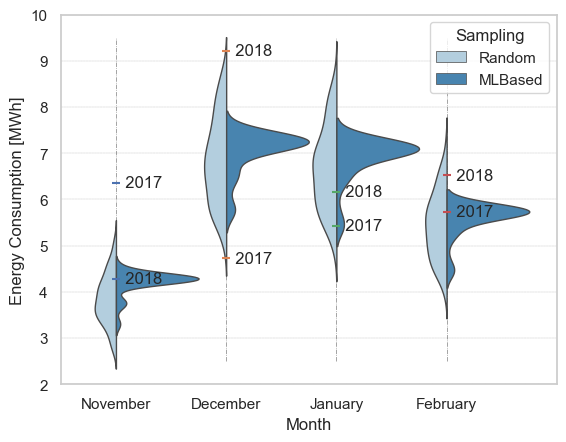

In [176]:
#half violin plots using seaborn graph
#upper values: parameter estimation (in results: simulationdata.values)
#lower values: combinations, last columns
#y1, y2 from Targets (measured values)
import seaborn as sns
sns.set_theme(style="whitegrid")

data = pd.DataFrame()
for x, month in enumerate(results):
  plt.vlines(x, 2.5, 9.5, lw=0.5, color="grey", linestyle = '-.', zorder=-1) 
  
  d1 = pd.DataFrame()
  d1['Energy'] = results[month]
  d1['Sampling'] = 'Random'
  d1['Month'] = month

  d2= pd.DataFrame()
  d2['Energy'] = Combinations[f'Predicted_{x}']
  d2['Sampling'] = 'MLBased'
  d2['Month'] = month

  data = pd.concat((data, d1, d2))

ax=sns.violinplot(data=data, width=1.5, x="Month", y="Energy", hue="Sampling", split=True, inner=None, linewidth=1, palette="Blues")
# sns.despine(left=True)

for i, value in Targets.iterrows():
    plt.scatter([i, i], value, marker='_')
    for x, z in enumerate(['2017', '2018']):
        plt.text(i, value[x], f' {z}', verticalalignment='center')


# Set x-axis label
#plt.xlabel('Month')
# Set y-axis label
plt.ylabel('Energy Consumption [MWh]')
plt.xlim(-0.5, 4.0)
plt.ylim(2, 10)
plt.grid(axis='y', color='k', linestyle='--', linewidth=0.1)
plt.savefig('violin.pdf')
plt.show()


In [161]:
value

value1    6.361
value2    4.283
Name: November, dtype: float64